In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.io import loadmat

from aux import loadmat_h5, get_seg, get_outliers, mv_avg, align_t, zscore
from disp import set_plot, get_line

cc = np.concatenate

T_MAX = 420
T_NRL = np.arange(T_MAX)
NROI = 20

T_SINE = np.array([40, 70, 100])
T_PULSE = np.array([130, 160, 190])
T_NAT = np.array([220, 300, 380, 460])

FLY_IDX = 0

FLIES = ['221014_a1']
EXPTS = [
    [f'{FLIES[0]}_{ctr}' for ctr in range(2,3)],
]

BHV_IDX_FRAME = 1
BHV_IDX_TIME = 21
BHV_IDX_SPEED = 18
DT_BHV = 1

# FNAME_STIM = 'data/original/lin_imaging/nat_song_imaging/10min_blocksplus_stim_1_forplotting.mat'
# SAVE_DIR = f'data/view/lin_20220830'

In [2]:
# load behav
expts = EXPTS[FLY_IDX]
ntr = len(expts)

tbhvs = []
spds = []

for expt in expts:

    fname_bhv = f'data/original/lin_imaging/nat_song_imaging/{expt}/output.txt'

    df_bhv = pd.read_csv(fname_bhv, header=None)

    # df_bhv
    tbhv = np.array(df_bhv)[:, BHV_IDX_TIME] - np.array(df_bhv)[0, BHV_IDX_TIME]
    # converts to time in seconds
    spd = np.array(df_bhv)[:, BHV_IDX_SPEED].astype(float)
    
    tbhvs.append(tbhv)
    spds.append(spd)
    
# clean up time vectors and signal alignment
tbase, spds = align_t(tbhvs, spds, dt=DT_BHV)

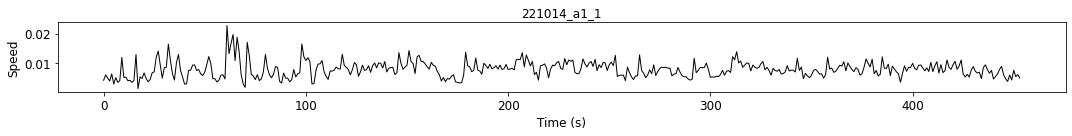

In [3]:
# plot behav
fig, ax = plt.subplots(1, 1, figsize=(15, 2*ntr), tight_layout=True, sharex=True)

for ctr, (spd, ax) in enumerate(zip(spds, [ax])):

    # plot stim and behav
    ax.plot(tbase, spd, c='k', lw=1)
    # plot_b(ax, tstim, stim, extent=[0, tstim.max(), -.01, -.005], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(ax, x_label='Time (s)', y_label='Speed', title=f'{FLIES[FLY_IDX]}_{ctr+1}', font_size=12)

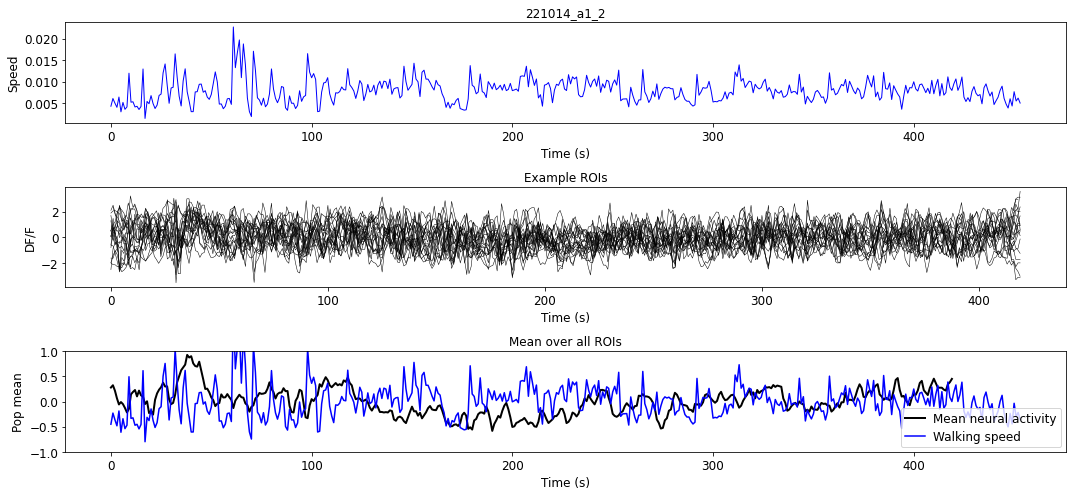

In [4]:
# load all neural data
dffs_all = []

expt = EXPTS[FLY_IDX][0]

data_dir = f'data/original/lin_imaging/nat_song_imaging/{expt}/supervoxels/'

dffs = []
slice_rois = []
for cslice in range(0, 9):
    fname = f'{expt}_n20_t420_slice{cslice}.h5'
    z_dff = loadmat_h5(os.path.join(data_dir, fname))['z_dff']

    for croi, dff in enumerate(z_dff.T):

        dff[get_outliers(dff, 3)] = np.nan
        dff = align_t([T_NRL], [dff], dt=DT_BHV, tbase=tbase)[1][0]
        dff = mv_avg(tbase, dff, 3)

        # z-score
        dff -= np.nanmean(dff)
        dff /= np.nanstd(dff)

        dffs.append(dff)
        
        slice_rois.append((cslice, croi+1))

dffs = np.array(dffs)
dffs_all.append(dffs)

fig, axs = plt.subplots(3, 1, figsize=(15, 7), tight_layout=True)
axs[0].plot(tbase, spds[0], c='b', lw=1)
set_plot(axs[0], x_label='Time (s)', y_label='Speed', title=f'{FLIES[FLY_IDX]}_2', font_size=12)

axs[1].plot(tbase, (dffs).T[:, :20], c='k', lw=.5)
set_plot(axs[1], x_label='Time (s)', y_label='DF/F', title='Example ROIs', font_size=12)

axs[2].plot(tbase, np.nanmean(dffs, axis=0), c='k', lw=2)
axs[2].plot(tbase, (spds[0]-np.nanmean(spds[0]))/np.nanstd(spds[0])/3, c='b')
axs[2].legend(['Mean neural activity', 'Walking speed'])
set_plot(axs[2], y_lim=(-1, 1), x_label='Time (s)', y_label='Pop mean', title='Mean over all ROIs', font_size=12)

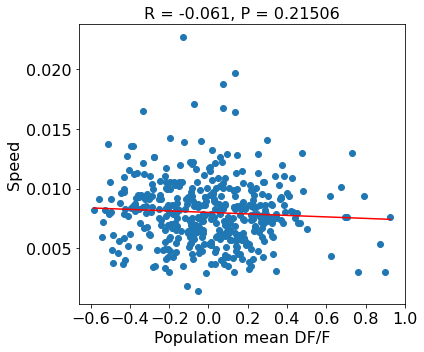

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)
dff_mn = np.nanmean(dffs, axis=0)
ax.scatter(dff_mn, spds[0])

x_ln, y_ln, (slp, icpt, r, pv, stderr) = get_line(dff_mn, spds[0])
ax.plot(x_ln, y_ln, c='r')
set_plot(ax, x_label='Population mean DF/F', y_label='Speed', title=f'R = {r:.3f}, P = {pv:.5f}', font_size=16)

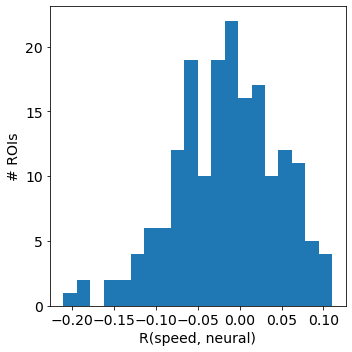

In [12]:
rs_all = []
for dff in dffs:
    r = get_line(dff, spds[0])[2][2]
    rs_all.append(r)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
ax.hist(rs_all, bins=20)
set_plot(ax, x_label='R(speed, neural)', y_label='# ROIs', font_size=14)

# Plot individual ROIs

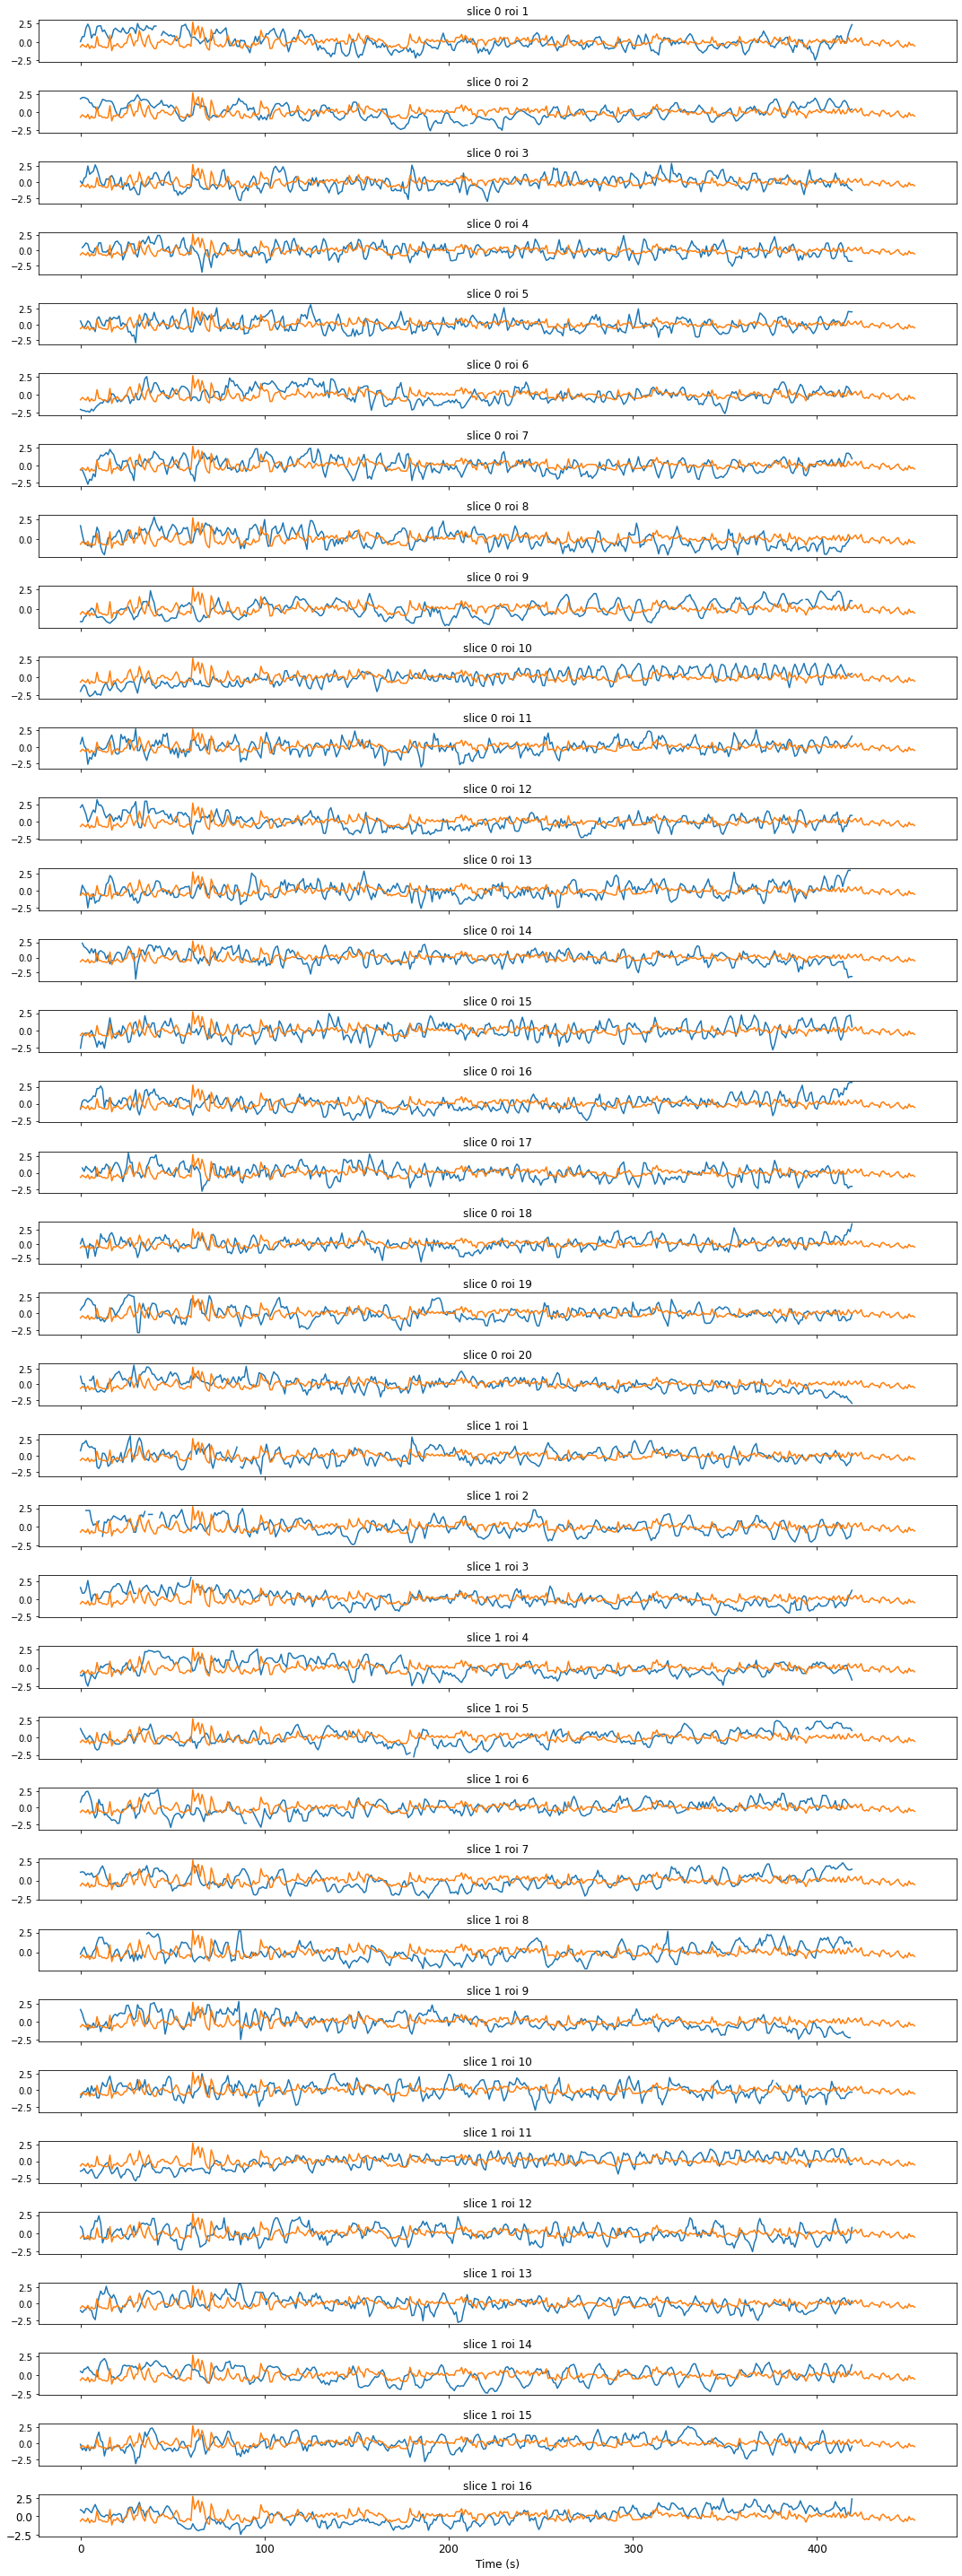

In [13]:
fig, axs = plt.subplots(36, 1, figsize=(15, 40), tight_layout=True, sharex=True)
n_per_ax = 1
for cax, ax in enumerate(axs):
    istart = cax*n_per_ax
    istop = (cax+1)*n_per_ax
    ax.plot(tbase, dffs.T[:, istart:istop])
    ax.plot(tbase, (spds[0]-np.nanmean(spds[0]))/np.nanstd(spds[0])/2)
    title = ', '.join([f'slice {cslice} roi {roi}' for cslice, roi in slice_rois[istart:istop]])
    set_plot(ax, title=title)
    
set_plot(axs[-1], x_label='Time (s)', font_size=12)

# Speed-neural cross covariances

Blue = original, black = detrended

....................................................................................................................................................................................

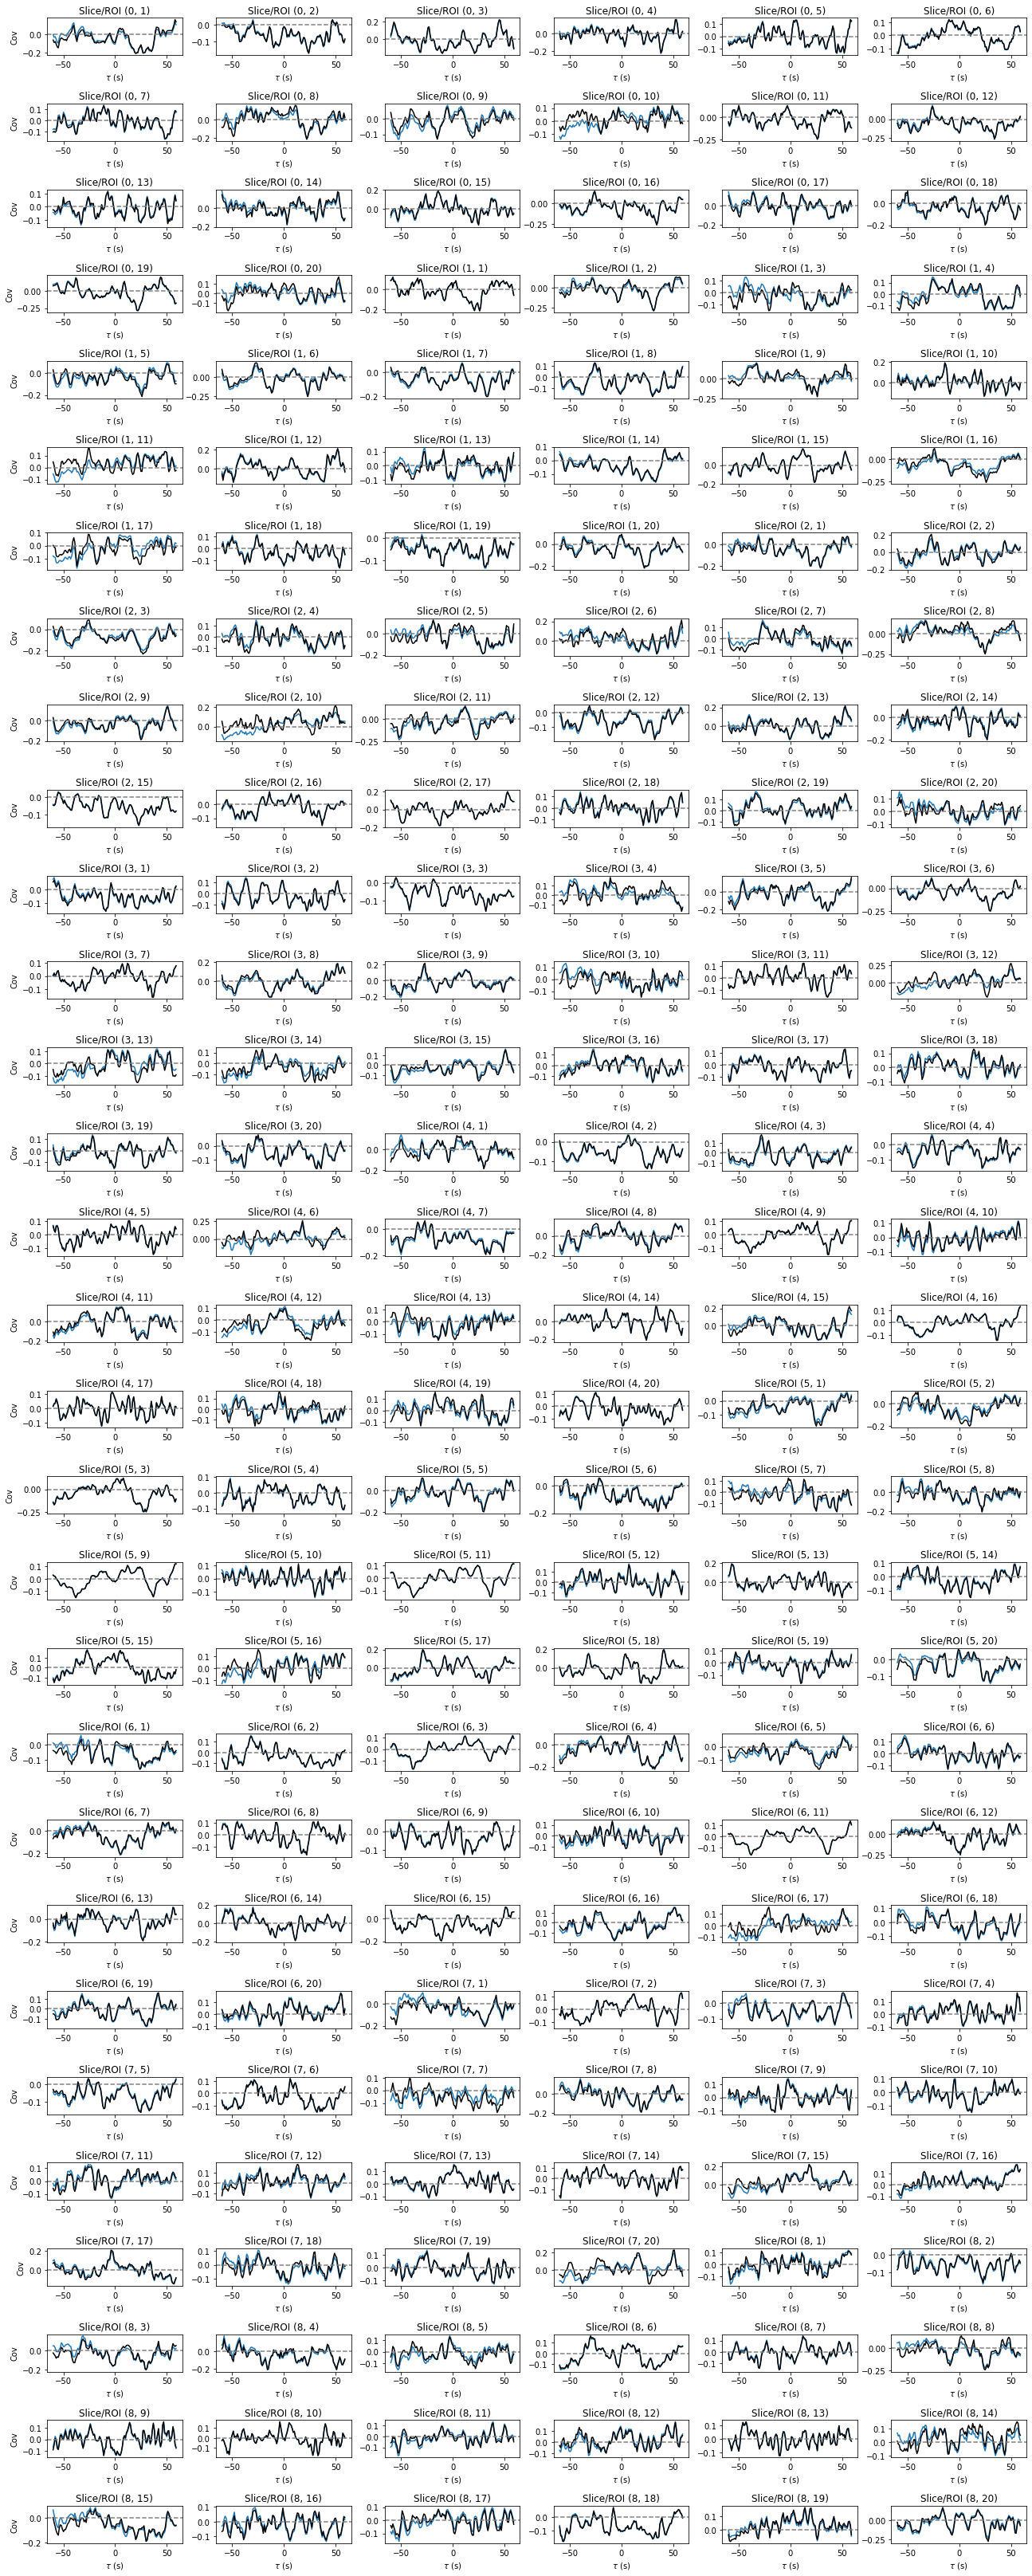

In [14]:
from time_stats import xcov_with_confidence, nan_detrend
import sys

lag = 60
tcov = np.arange(-lag, lag)

fig, axs = plt.subplots(30, 6, figsize=(18, 45), tight_layout=True)
for cax, (ax, dff) in enumerate(zip(axs.flatten(), dffs)):
    sys.stdout.write('.')
    cov = xcov_with_confidence(spds[0], dff, lag_forward=lag, lag_backward=lag, pre_norm=True)[0]
    ax.plot(tcov, cov)
    
    cov_det = xcov_with_confidence(spds[0], nan_detrend(dff), lag_forward=lag, lag_backward=lag, pre_norm=True)[0]
    ax.plot(tcov, cov_det, c='k')
    
    ax.axhline(0, ls='--', color='gray')
    set_plot(ax, x_label=r'$\tau$ (s)', title=f'Slice/ROI {slice_rois[cax]}')
    
for ax in axs[:, 0]:
    set_plot(ax, y_label='Cov')